In [1]:
import os
import pandas as pd 
import numpy as np 

# visualisation
import matplotlib.pylab as plt
import matplotlib.font_manager as fm

# our scripts 
import src.processing as sp 
import settings as st
import utils.helpers as hp
import utils.imaging as ui

### Correct for the locations of the images 

In [2]:
%%capture
!git pull

In [3]:
# dr5_desc = sp.correct_location('gz_decals_volunteers_5', save = True, filename='dr5_votes')

### The data with the votes

In [2]:
dataframe = hp.read_parquet(st.DATA_DIR, 'descriptions/dr5_votes')

In [3]:
labels = sp.generate_labels(dataframe, save=False)

In [4]:
labels.head()

,iauname,png_loc,Smooth,Featured or Disk,Artifact,Round,In Between,Cigar Shaped,Edge On Disk (Yes),Edge On Disk (No),...,Spiral Arms (2),Spiral Arms (3),Spiral Arms (4),Spiral Arms (More Than 4),Spiral Arms (cannot tell),Central Bulge (None),Central Bulge (Small),Central Bulge (Moderate),Central Bulge (Large),Central Bulge (Dominant)
0,J112953.88-000427.4,J112/J112953.88-000427.4.png,1,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
1,J104325.29+190335.0,J104/J104325.29+190335.0.png,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,J104629.54+115415.1,J104/J104629.54+115415.1.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,1,1,0,0
3,J082950.68+125621.8,J082/J082950.68+125621.8.png,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,J122056.00-015022.0,J122/J122056.00-015022.0.png,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [5]:
# labels.to_csv('ml/labels.csv')

# Calculate the weights per class

In [5]:
labels_num = labels.iloc[:,2:]
weights = labels_num.sum(axis=0)
inv_weights = 1/weights
inv_weights_norm = inv_weights/inv_weights.sum()

In [6]:
inv_weights_norm

Smooth                         0.002821
Featured or Disk               0.005690
Artifact                       0.057493
Round                          0.006431
In Between                     0.003816
Cigar Shaped                   0.011399
Edge On Disk (Yes)             0.010705
Edge On Disk (No)              0.003131
Merging (Merger)               0.024418
Merging (Major Disturbance)    0.041934
Merging (Minor Disturbance)    0.017971
Merging (None)                 0.002253
Bulge (Rounded)                0.008159
Bulge (Boxy)                   0.057669
Bulge (None)                   0.023825
No Bar                         0.003642
Weak Bar                       0.014607
Strong Bar                     0.029243
Spiral Arms (Yes)              0.006750
Spiral Arms (No)               0.004657
Spiral Winding (Tight)         0.010099
Spiral Winding (Medium)        0.013962
Spiral Winding (Loose)         0.020519
Spiral Arms (1)                0.055613
Spiral Arms (2)                0.009501


# Split into train, test and validate

In [8]:
train_val_test = sp.split_data(labels, 0.05, 0.15, save=False)

In [9]:
train_val_test['train'].shape

(202628, 36)

In [10]:
train_val_test['validate'].shape

(12665, 36)

In [11]:
train_val_test['test'].shape

(37993, 36)

In [12]:
labels.shape

(253286, 36)

### DataLoader

In [3]:
from src.dataset import DECaLSDataset
from torch.utils.data import Dataset, DataLoader

In [4]:
traindataset = DECaLSDataset(mode = 'train', augment = False, multi_task = True)

The number of training points is 189963


In [10]:
train_loader = DataLoader(dataset=traindataset, batch_size=4, shuffle=True)

In [11]:
dataiter = iter(train_loader)

In [12]:
data = dataiter.next()

In [20]:
sp.find_labels({'task_'+str(i+1): data[1][i][2].tolist() for i in range(10)})

array(['Featured or Disk', 'Edge On Disk (Yes)', 'Bulge (Rounded)',
       'Merging (None)'], dtype='<U27')

# Test Network

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# our scripts and functions
from src.network import MultiLabelNet, MultiTaskNet
from src.dataset import DECaLSDataset
import settings as st

In [2]:
out_path = './output/'
os.makedirs(out_path, exist_ok=True)

# Set device to CUDA if a CUDA device is available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the dataloader
train_dataset = DECaLSDataset(mode='train', augment=False, multi_task = True)
val_dataset = DECaLSDataset(mode='validate', augment=False, multi_task = True)

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

The number of training points is 189963
The number of validation points is 12665


In [3]:
# %%capture
# model = MultiLabelNet(backbone="resnet18")
# model.to(device)

In [4]:
LABELS_PER_TASK = {'task_1': 3,
                   'task_2': 3,
                   'task_3': 2,
                   'task_4': 4,
                   'task_5': 3,
                   'task_6': 3,
                   'task_7': 2,
                   'task_8': 3,
                   'task_9': 6,
                   'task_10': 5
                   }

In [5]:
%%capture
model = MultiTaskNet(backbone="resnet18", output_size=LABELS_PER_TASK, resnet_task = True)
model.to(device)

In [6]:
data = next(iter(train_loader))

In [7]:
def criterion(loss, outputs: nn.ModuleDict, labels: dict) -> torch.tensor:
    losses = 0
    for i, key in enumerate(outputs):
        # print(outputs[key])
        # print(labels[key])
        losses += loss(outputs[key], labels[key].float().to(device))
    return losses

In [7]:
outputs = model(data[0].to(device))

In [8]:
outputs = model(data[0].to(device))
labels = data[1]
loss = nn.BCEWithLogitsLoss()
l = criterion(loss, outputs, labels)

# If We Want to Use Shared Representation

- Also implemented a ResNet in 1D. 

In [ ]:
import torch.nn.functional as F

In [26]:
tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])

In [32]:
feat = tf_last_layer_chopped(data[0].to(device))

In [34]:
f = feat.to('cpu')

In [69]:
conv1 = nn.Conv1d(1, 1, kernel_size=3, stride=2, padding = (3 - 1)//2)
bn1 = nn.BatchNorm1d(1)
conv2 = nn.Conv1d(1, 1, kernel_size=3, stride=2, padding = (3 - 1)//2)
bn2 = nn.BatchNorm1d(1)

In [99]:
features = f.unsqueeze(1)

In [100]:
out = conv1(features)
out = bn1(out)
out = F.relu(out)
out = conv2(out)
out = bn2(out)

In [101]:
nout = out.shape[-1]
nfeat = features.shape[-1]
left = (1000 - nout) // 2
right = 1000 - left - nout

In [102]:
out = F.pad(input=out, pad=(left, right), mode='constant', value=0)

In [103]:
out += features
out = F.relu(out)

In [107]:
out = conv1(out)
out = bn1(out)
out = F.relu(out)
out = conv2(out)
out = bn2(out)

In [108]:
out.shape

torch.Size([4, 1, 250])

In [138]:
resnet_layer = nn.Sequential(*list(model.children())[:-1])

In [135]:
model_1 = nn.Sequential(*list(model.children())[1]['task_1'].layers[:-1])

In [137]:
# from torchsummary import summary
# summary(model, (1, 224, 224))

# Embedding Vector

In [74]:
import torch
import torch.nn as nn 
from src.network import MultiLabelNet
from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader
import settings as st

import os
from PIL import Image
import matplotlib.pylab as plt

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
# load the model
%%capture
loaded_model = torch.load('../ml-models/resnet_18_multilabel_24.pth')
model = MultiLabelNet(backbone="resnet18")
model.to(device)
model.load_state_dict(loaded_model)
model.eval()

UsageError: Line magic function `%%capture` not found.


In [77]:
tf_last_layer_chopped = nn.Sequential(*list(model.children())[:-1])

In [78]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 50658


In [96]:
d1 = test_loader.dataset[0]
d2 = test_loader.dataset[1]
d3 = test_loader.dataset[2]
d4 = test_loader.dataset[3]

In [97]:
o1 = tf_last_layer_chopped(d1[0].view(1,1,224,224).to(device))
o2 = tf_last_layer_chopped(d2[0].view(1,1,224,224).to(device))
o3 = tf_last_layer_chopped(d3[0].view(1,1,224,224).to(device))
o4 = tf_last_layer_chopped(d4[0].view(1,1,224,224).to(device))

In [81]:
d1[1]

tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [82]:
d2[1]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [83]:
d3[1]

tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [98]:
d4[1]

tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

### Pairwise Distance

In [92]:
pdist = nn.PairwiseDistance(p=2)

In [93]:
pdist(o1, o2)

tensor([7.0306], device='cuda:0', grad_fn=<NormBackward1>)

In [94]:
pdist(o1, o3)

tensor([6.3318], device='cuda:0', grad_fn=<NormBackward1>)

In [95]:
pdist(o2, o3)

tensor([7.0053], device='cuda:0', grad_fn=<NormBackward1>)

In [103]:
pdist(o1, o4)

tensor([8.2538], device='cuda:0', grad_fn=<NormBackward1>)

In [104]:
pdist(o2, o4)

tensor([9.2016], device='cuda:0', grad_fn=<NormBackward1>)

In [105]:
pdist(o3, o4)

tensor([6.2826], device='cuda:0', grad_fn=<NormBackward1>)

### Cosine Similarity

In [84]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [85]:
cos(o1, o2)

tensor([0.5844], device='cuda:0', grad_fn=<DivBackward0>)

In [86]:
cos(o1, o3)

tensor([0.5753], device='cuda:0', grad_fn=<DivBackward0>)

In [87]:
cos(o2, o3)

tensor([0.5888], device='cuda:0', grad_fn=<DivBackward0>)

In [106]:
cos(o1, o4)

tensor([0.7079], device='cuda:0', grad_fn=<DivBackward0>)

In [107]:
cos(o2, o4)

tensor([0.6127], device='cuda:0', grad_fn=<DivBackward0>)

In [108]:
cos(o3, o4)

tensor([0.8876], device='cuda:0', grad_fn=<DivBackward0>)

In [101]:
test_dataset.desc.iloc[0:5]

,iauname,png_loc,smooth-or-featured_smooth_fraction,smooth-or-featured_featured-or-disk_fraction,smooth-or-featured_artifact_fraction,disk-edge-on_yes_fraction,disk-edge-on_no_fraction,has-spiral-arms_yes_fraction,has-spiral-arms_no_fraction,bar_strong_fraction,...,spiral-arm-count_1_fraction,spiral-arm-count_2_fraction,spiral-arm-count_3_fraction,spiral-arm-count_4_fraction,spiral-arm-count_more-than-4_fraction,spiral-arm-count_cant-tell_fraction,merging_none_fraction,merging_minor-disturbance_fraction,merging_major-disturbance_fraction,merging_merger_fraction
0,J140957.60+062506.1,J140/J140957.60+062506.1.png,1,0,0,0,1,1,0,1,...,0,1,0,0,0,0,1,0,0,0
1,J164313.15+261827.0,J164/J164313.15+261827.0.png,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,J150934.55+045229.1,J150/J150934.55+045229.1.png,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,J113334.66-021647.5,J113/J113334.66-021647.5.png,0,1,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,J101906.78+231837.7,J101/J101906.78+231837.7.png,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


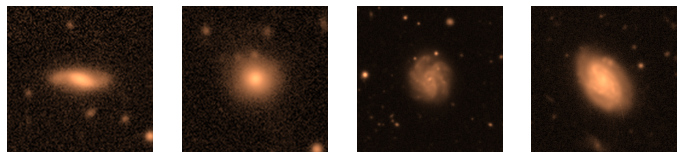

In [119]:
name = 'copper'
plt.figure(figsize = (12, 8))
plt.subplot(141)
plt.imshow(d1[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(142)
plt.imshow(d2[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(143)
plt.imshow(d3[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(144)
plt.imshow(d4[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()

# Pie Chart

- To repeat this for the entire dataset. 

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt 
import matplotlib as cm
import settings as st
import os 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 25

In [23]:
dataframe = pd.read_csv('ml/labels.csv')

In [24]:
def calc_percent_task(table: pd.DataFrame, task_number: int = 1):
    
    # sum across columns
    column_sum = table[st.LABELS['task_' + str(task_number)]].sum(0)
    
    # calculate percentage
    percentage = column_sum / column_sum.sum() * 100
    
    return percentage

In [25]:
test = [calc_percent_task(dataframe, i + 1) for i in range(10)]

In [26]:
def plot_pie(index: int = 0, save: bool = False):
    nobject = len(test[index].values)
    colors = iter([plt.cm.Pastel1(k) for k in range(nobject)])
    fig1, ax1 = plt.subplots(figsize=(12,12))
#     fig1.set_figheight(8)
#     fig1.set_figwidth(8)
    patches, texts, autotexts = ax1.pie(test[index].values, labels=test[index].keys(), autopct='%1.1f%%', shadow=False, colors = colors)
    plt.setp(texts, fontsize=fontSize)
    plt.setp(autotexts, fontsize=fontSize)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    ax1.axis('equal') 
    
    if save:
        path = 'plots/pie/'
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + 'pie_' + str(index) + '.pdf', bbox_inches = 'tight')
        plt.savefig(path + 'pie_' + str(index) + '.png', bbox_inches = 'tight')
        plt.close()
        
    else:
        plt.show()

In [27]:
# for i in range(10):
#     plot_pie(i, True)

# Predictions from MTL Network

In [25]:
import settings as st 
import utils.helpers as hp
import src.processing as sp
import pandas as pd

from src.dataset import DECaLSDataset
from torch.utils.data import DataLoader

import matplotlib.pylab as plt 
import matplotlib as cm

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 25

In [2]:
def labels_test(test: pd.DataFrame, index: int = 0):
    
    # the first two column names are the name and png locations
    labels = test.iloc[index, 2:]
    
    label_dict = dict()
    for i in range(st.NUM_TASKS):
        task = labels[st.LABELS['task_' + str(i + 1)]].values.astype(int)
        label_dict['task_' + str(i + 1)] = task
        
    return label_dict

Load the predictions

In [3]:
preds = hp.load_pickle('results', 'predictions_mtl')

Load the test set

In [4]:
test = hp.load_csv(st.DATA_DIR, 'ml/test')

Make predictions on the first test point

In [5]:
idx =1546

In [6]:
test_point = labels_test(test, idx)

In [7]:
sp.find_labels(test_point)

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,[Smooth],[Round],NaN,[Merging (None)],NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
sp.find_labels(preds[idx])

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,[Smooth],[Round],NaN,[Merging (None)],NaN,NaN,NaN,NaN,NaN,NaN


### Iterate over all objects

In [9]:
ntest = test.shape[0]
tree_pred = list()
tree_test = list()

for idx in range(ntest):
    
    # re-write the test point in a dictionary (label per task)
    test_point = labels_test(test, idx)
          
    # find the labels (ground truths and test point
    pred_labels = sp.find_labels(preds[idx])
    test_labels = sp.find_labels(test_point)
    
    # record the trees
    tree_pred.append(pred_labels)
    tree_test.append(test_labels)

In [17]:
tree_pred_df = pd.concat(tree_pred)
tree_test_df = pd.concat(tree_test)

In [18]:
tree_pred_df.reset_index(drop=True, inplace=True)
tree_test_df.reset_index(drop=True, inplace=True)

In [44]:
tree_pred_df.iloc[15:19]

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
15,[Smooth],[In Between],NaN,[Merging (None)],NaN,NaN,NaN,NaN,NaN,NaN
16,[Smooth],[Cigar Shaped],NaN,[Merging (None)],NaN,NaN,NaN,NaN,NaN,NaN
17,[Featured or Disk],NaN,[Edge On Disk (No)],[Merging (None)],NaN,[Weak Bar],[Spiral Arms (Yes)],[Spiral Winding (Tight)],[Spiral Arms (2)],[Central Bulge (Small)]
18,[Smooth],[Cigar Shaped],NaN,[Merging (None)],NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
tree_test_df.iloc[15:19]

,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
15,[Smooth],[In Between],NaN,[Merging (None)],NaN,NaN,NaN,NaN,NaN,NaN
16,"[Smooth, Featured or Disk]",[Cigar Shaped],NaN,[Merging (Minor Disturbance)],NaN,NaN,NaN,NaN,NaN,NaN
17,[Featured or Disk],NaN,[Edge On Disk (No)],[Merging (Minor Disturbance)],NaN,"[No Bar, Weak Bar]",[Spiral Arms (Yes)],[Spiral Winding (Medium)],"[Spiral Arms (1), Spiral Arms (3), Spiral Arms...",[Central Bulge (Small)]
18,[Smooth],[Cigar Shaped],NaN,[Merging (None)],NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
test_dataset = DECaLSDataset(mode='test', augment=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

The number of test points is 37993


In [46]:
d1 = test_loader.dataset[15]
d2 = test_loader.dataset[16]
d3 = test_loader.dataset[17]
d4 = test_loader.dataset[18]

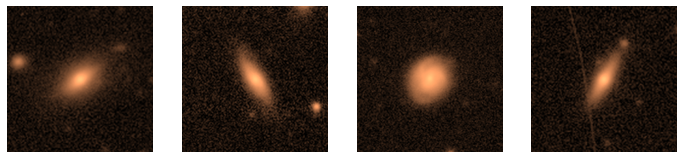

In [47]:
name = 'copper'
plt.figure(figsize = (12, 8))
plt.subplot(141)
plt.imshow(d1[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(142)
plt.imshow(d2[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(143)
plt.imshow(d3[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')

plt.subplot(144)
plt.imshow(d4[0].permute(1, 2, 0), cmap=plt.get_cmap(name))
plt.axis('off')
plt.show()